In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import skimage.io as io
import numpy as np
from skimage import feature
from sklearn.decomposition import RandomizedPCA
from sklearn.manifold import TSNE
import glob, os
from imp import reload
import json
import sys
sys.path.append('../')
import helpers.image_processing as im

***What classes are there inside the dataset:***

In [5]:
with open('../data/food-101/meta/classes.txt') as f:
    classes = f.read().splitlines()

In [7]:
print("Num classes: {}".format(len(classes)))

Num classes: 101


In [8]:
im.print_columns(classes, 3)

apple_pie                     eggs_benedict                 onion_rings                   
baby_back_ribs                escargots                     oysters                       
baklava                       falafel                       pad_thai                      
beef_carpaccio                filet_mignon                  paella                        
beef_tartare                  fish_and_chips                pancakes                      
beet_salad                    foie_gras                     panna_cotta                   
beignets                      french_fries                  peking_duck                   
bibimbap                      french_onion_soup             pho                           
bread_pudding                 french_toast                  pizza                         
breakfast_burrito             fried_calamari                pork_chop                     
bruschetta                    fried_rice                    poutine                       

***We will cross the available dataset with popular recipe searches on Google:***

In [9]:
keywords = pd.read_csv('../data/keywords.csv', encoding='utf-16le', sep='\t')
keywords = keywords.sort_values(by='Avg. Monthly Searches (exact match only)', ascending=False)
keywords['Keyword'] = keywords['Keyword'].str.replace('recipes', '')
keywords['Keyword'] = keywords['Keyword'].str.replace('recipe', '')
keywords['Keyword'] = keywords['Keyword'].str.strip()

In [10]:
top_searches = list(keywords['Keyword'])[:100]
classes_cleaned = [c.replace('_', ' ') for c in classes]
top = []
for t in top_searches:
    if t in classes_cleaned:
        top.append(t)

In [11]:
print("Of top 100 Google searches, {} coincide with classes in image dataset.".format(len(top)))

Of top 100 Google searches, 13 coincide with classes in image dataset.


***Focus on top 12:***

In [12]:
top_12 = top[:12]
for t in top_12:
    print(t)

pork chop
lasagna
french toast
guacamole
apple pie
cheesecake
hamburger
fried rice
carrot cake
chocolate cake
steak
pizza


In [13]:
top_12_classes = [t.replace(" ", "_") for t in top_12]

***Look at some data about the images in the top 12 classes:***

In [16]:
imd = pd.read_csv('../data/food-101/meta/top_classes.csv')

In [11]:
#Most frequent image size:
(imd.groupby('shape').size().sort_values(ascending=False) / len(imd) * 100).head(1)

shape
(512, 512, 3)    59.375
dtype: float64

***So 60% of the images have shape 512 x 512; this will be the size we use for standardizing all images.***

In [193]:
S = (512, 512, 3)

***Get average image by pixel values for the top 12 classes:***

In [12]:
names = top_12_classes
avg_images = []

In [14]:
for n in names:
    avg_images.append(np.load((os.path.join('../data/food-101/top_classes/averages', n) + '.npy')))

***Plot the RGB histograms for the average images for each of the 12 classes.***

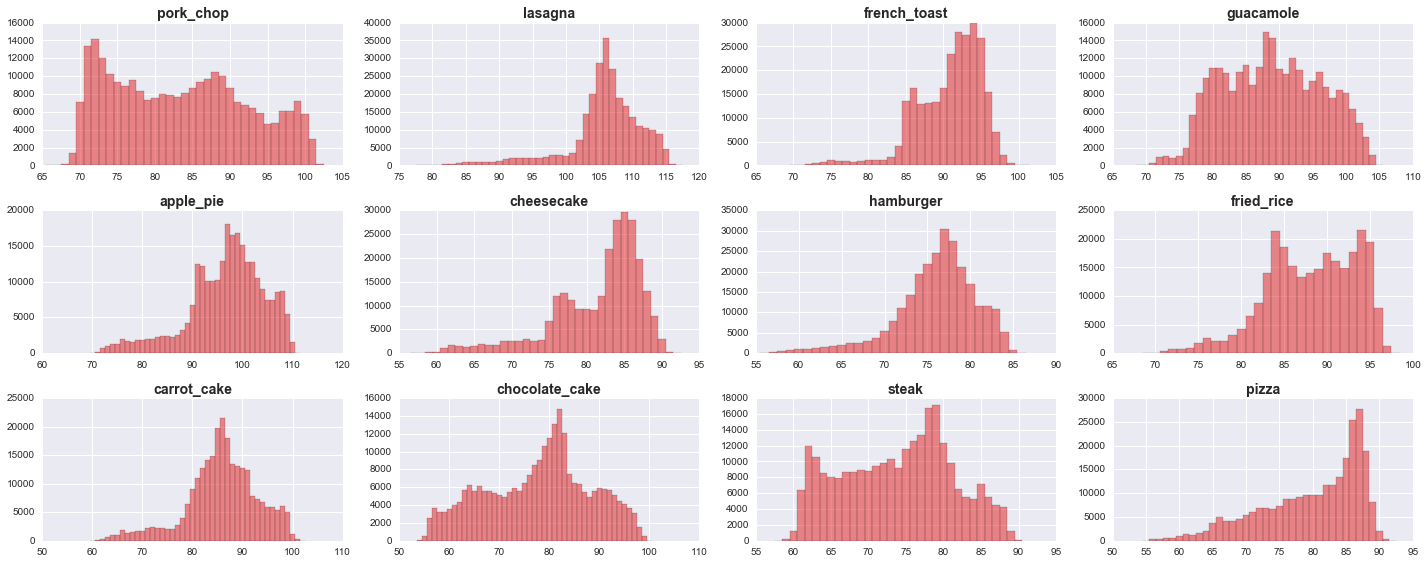

In [51]:
im.plot_histogram(avg_images, names, 0)

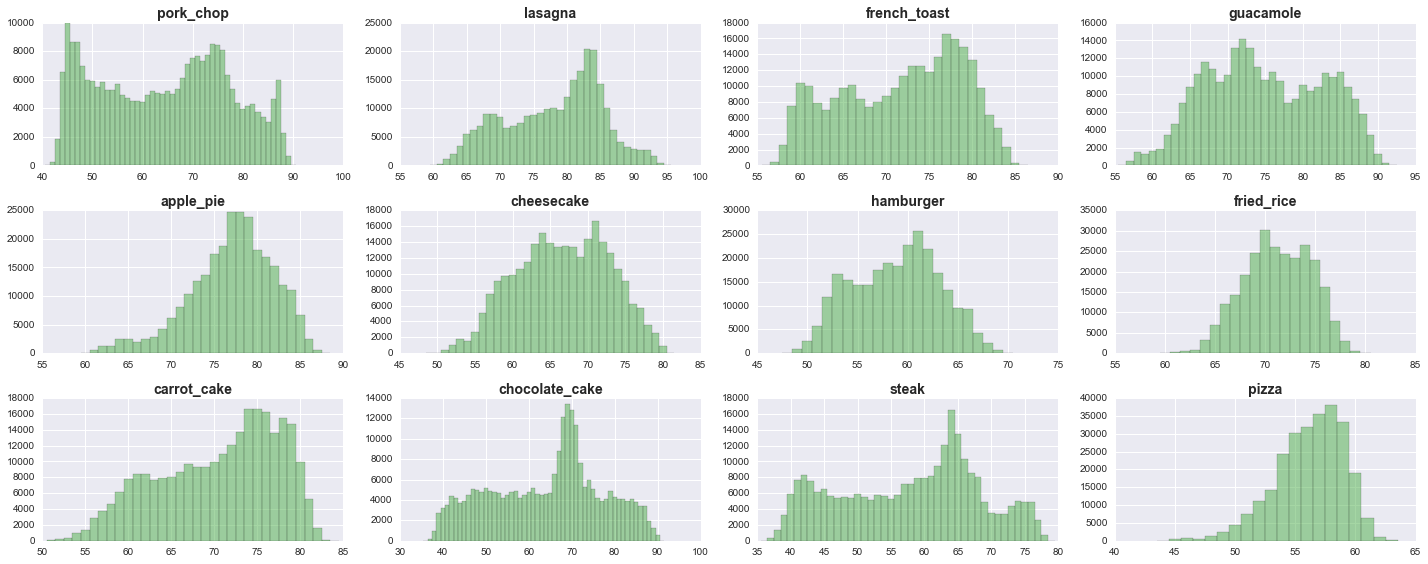

In [44]:
im.plot_histogram(avg_images, names, 1)

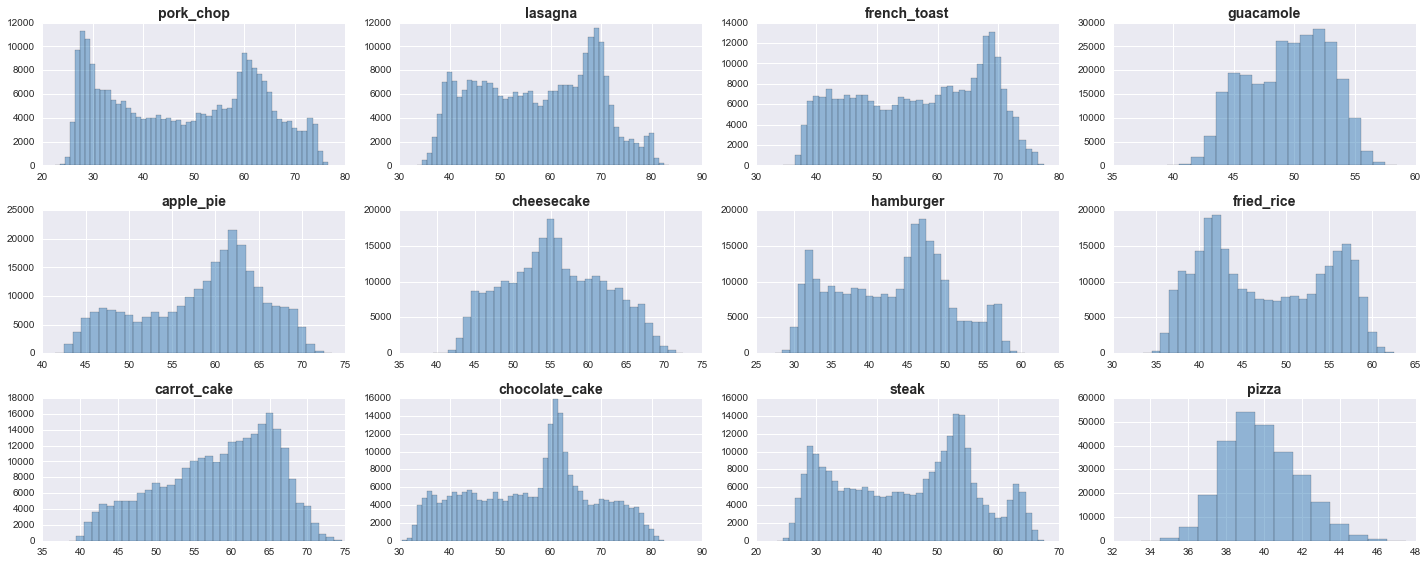

In [45]:
im.plot_histogram(avg_images, names, 2)

***Find the 40 'closest' images to the average for each of the 12 classes***

In [14]:
averages = {}
for c in top_12_classes:
    averages[c] = np.load('../data/food-101/top_classes/averages/' + c + '.npy')

In [18]:
closest_40 = {}

for c in top_12_classes:
    images = list(imd[imd['class'] == c]['name'])
    path = '../data/food-101/images/' + c + '/'
    neighbors = im.nearest_neighbors(averages[c], images, 40, path)
    closest_40[c] = neighbors

In [19]:
# Save for future use
json.dump(closest_40, open('../data/food-101/top_classes/closest_40_images.txt', "w"))

In [53]:
closest_40 = json.load(open('../data/food-101/top_classes/closest_40_images.txt', "r"))

***Plot images on 2-D:***

In [54]:
data = []
path = '../data/food-101/top_classes/'
for c in top_12_classes:
    for i in closest_40[c]:
        img = io.imread(path + c + '/' + i)
        data.append(img.flatten())

In [55]:
pca = RandomizedPCA(n_components=50)
X = pca.fit_transform(data)

In [56]:
model = TSNE(n_components=2, random_state=0)
transformed = model.fit_transform(X)

In [57]:
fitted = {}
i = 0
for c in top_12_classes:
    fitted[c] = transformed[i*40:(i + 1)*40]
    i += 1

In [58]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

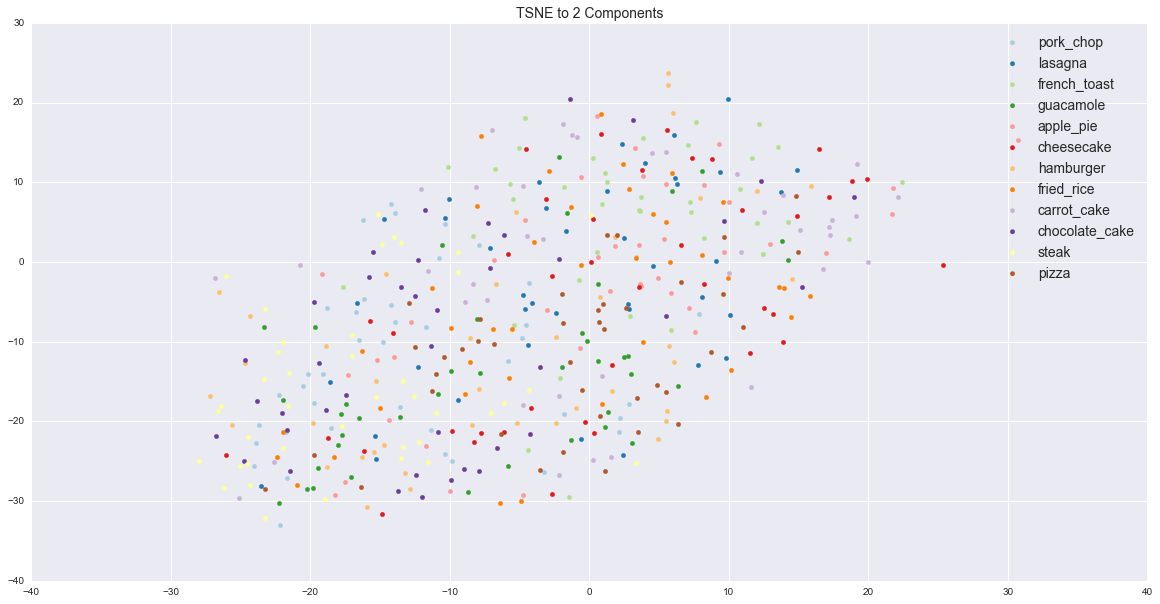

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
i = 0
for c in top_12_classes:
    x = fitted[c][:, 0]
    y = fitted[c][:, 1]
    ax.scatter(x, y, color=colors[i], label=c)
    i += 1

ax.set_title('TSNE to 2 Components', fontsize='14')
ax.legend(prop={'size':14})
plt.show()

***Look at classifications by pre-trained model for the 10 'most representative' images for each class, as defined by the top 10 closest images to the mean:***

In [146]:
pre_trained = pd.read_csv('../data/food-101/top_classes/pre_trained_tags.csv', index_col=0)

In [180]:
for c in top_12_classes:
    print(c)
    for t in list(pre_trained[pre_trained['class'] == c]['tag']):
        print(t)
    print("\n")

pork_chop
a plate of food with meat and vegetables
a plate of food with a sandwich on it
a plate of food with meat and vegetables
a white plate topped with meat and vegetables
a piece of cake on a plate with a fork
a plate with a sandwich and a salad
a plate of food with meat and vegetables
a white plate topped with a sandwich and a salad
a plate of food with a sandwich and a salad
a plate of food with a fork and knife


lasagna
a plate of food with a fork and spoon
a close up of a slice of pizza on a plate
a plate of food with a fork and a glass of wine
a close up of a plate of food on a table
a white plate topped with meat and vegetables
a close up of a pizza on a plate
a white plate topped with a piece of food
a plate with a piece of pizza on it
a close up of a pizza on a plate
a close up of a piece of pizza on a plate


french_toast
a plate with a sandwich and a bowl of soup
a plate of food with a fork and a fork
a close up of a pizza on a plate
a close up of a pizza on a plate
a s

***Save standardized versions of all images for future processing***

In [207]:
import warnings

In [195]:
for c in top_12_classes:
    os.mkdir('../data/food-101/top_classes/' + c)

In [209]:
for c in top_12_classes:
    path = '../data/food-101/images/' + c + '/'
    images = glob.glob1(path, '*.jpg')
    for i in images:
        img = im.standardize(i, S, path)
        new_path = '../data/food-101/top_classes/' + c + '/' + i
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            io.imsave(new_path, img)